In [1]:
import logging
import warnings
import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

import pandas as pd
import numpy as np

from time import time
from pathlib import Path
from collections import defaultdict

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

CORES = multiprocessing.cpu_count()
DATA_PATH = './data'

# Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
corpus_file = '{}/models/corpus.csv.xz'.format(DATA_PATH)
df = pd.read_csv(corpus_file, header=None, compression='xz')
df.head(10)

,0
0,isol complex polynomi root algebra algorithm u...
1,algebra algorithm isol complex polynomi zero u...
2,use comput algebra chebyshev polynomi count po...
3,review sacarweb design base discount usabl engin
4,extend immers learn environ hybrid remot virtu...
5,new technolog inform commun pwm remot experi 3...
6,school vs industri relat compet skill
7,3d virtual world use open sourc platform integ...
8,technolog plc power line commun use monitor sy...
9,immers learn environ use 3d virtual world inte...


In [3]:
sent = [row.split() for row in df[0]]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 11:20:39: collecting all words and their counts
INFO - 11:20:39: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 11:20:39: PROGRESS: at sentence #10000, processed 86343 words and 67578 word types
INFO - 11:20:39: PROGRESS: at sentence #20000, processed 173713 words and 120639 word types
INFO - 11:20:39: PROGRESS: at sentence #30000, processed 261044 words and 168767 word types
INFO - 11:20:39: PROGRESS: at sentence #40000, processed 348754 words and 212902 word types
INFO - 11:20:39: PROGRESS: at sentence #50000, processed 436616 words and 254373 word types
INFO - 11:20:40: PROGRESS: at sentence #60000, processed 513692 words and 283710 word types
INFO - 11:20:40: PROGRESS: at sentence #70000, processed 593179 words and 311593 word types
INFO - 11:20:40: PROGRESS: at sentence #80000, processed 671464 words and 337415 word types
INFO - 11:20:40: PROGRESS: at sentence #90000, processed 749581 words and 361880 word types
INFO - 11:20:40: PROGRESS: at sentence #1

In [4]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

print(len(word_freq))
print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

48042
['use', 'base', 'system', 'model', 'analysi', 'network', 'approach', 'applic', 'data', 'design']


In [5]:
model = Word2Vec(min_count=20, window=2, size=300, sample=6e-5,
                 alpha=0.03, min_alpha=0.0007, negative=20, workers=CORES-1)

In [6]:
t = time()
model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 11:20:53: collecting all words and their counts
INFO - 11:20:53: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 11:20:54: PROGRESS: at sentence #10000, processed 81181 words, keeping 12349 word types
INFO - 11:20:54: PROGRESS: at sentence #20000, processed 163400 words, keeping 18587 word types
INFO - 11:20:54: PROGRESS: at sentence #30000, processed 245578 words, keeping 23611 word types
INFO - 11:20:55: PROGRESS: at sentence #40000, processed 328184 words, keeping 27949 word types
INFO - 11:20:55: PROGRESS: at sentence #50000, processed 410690 words, keeping 32071 word types
INFO - 11:20:55: PROGRESS: at sentence #60000, processed 482524 words, keeping 34102 word types
INFO - 11:20:56: PROGRESS: at sentence #70000, processed 556643 words, keeping 35948 word types
INFO - 11:20:56: PROGRESS: at sentence #80000, processed 629502 words, keeping 37807 word types
INFO - 11:20:56: PROGRESS: at sentence #90000, processed 702305 words, keeping 39543 word types

In [7]:
t = time()
model.train(sentences, total_examples=model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

t_qsize 0
INFO - 11:22:48: EPOCH 12 - PROGRESS: at 90.98% examples, 56183 words/s, in_qsize 0, out_qsize 0
INFO - 11:22:49: worker thread finished; awaiting finish of 2 more threads
INFO - 11:22:49: worker thread finished; awaiting finish of 1 more threads
INFO - 11:22:49: worker thread finished; awaiting finish of 0 more threads
INFO - 11:22:49: EPOCH - 12 : training on 1105573 raw words (502485 effective words) took 9.1s, 55416 effective words/s
INFO - 11:22:50: EPOCH 13 - PROGRESS: at 8.57% examples, 44520 words/s, in_qsize 0, out_qsize 0
INFO - 11:22:52: EPOCH 13 - PROGRESS: at 19.45% examples, 50485 words/s, in_qsize 0, out_qsize 0
INFO - 11:22:53: EPOCH 13 - PROGRESS: at 31.10% examples, 55222 words/s, in_qsize 0, out_qsize 0
INFO - 11:22:54: EPOCH 13 - PROGRESS: at 44.11% examples, 56887 words/s, in_qsize 0, out_qsize 0
INFO - 11:22:55: EPOCH 13 - PROGRESS: at 58.21% examples, 57748 words/s, in_qsize 0, out_qsize 0
INFO - 11:22:56: EPOCH 13 - PROGRESS: at 68.59% examples, 55912 

### T-SNE Plot

In [8]:
def tsnescatterplot(model, word, list_names):
    """ 
    Plot in seaborn the results from the t-SNE dimensionality
    reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

INFO - 11:25:22: precomputing L2-norms of word weight vectors


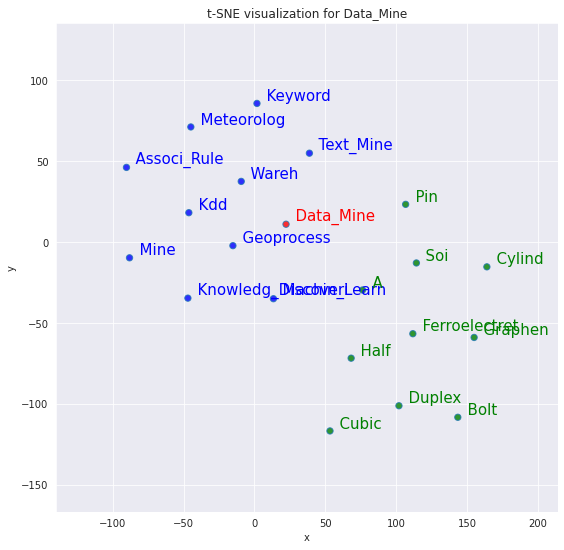

In [9]:
# 10 Most similar words vs. 10 Most dissimilar
tsnescatterplot(model, 'data_mine', [i[0] for i in model.wv.most_similar(negative=["data_mine"])])

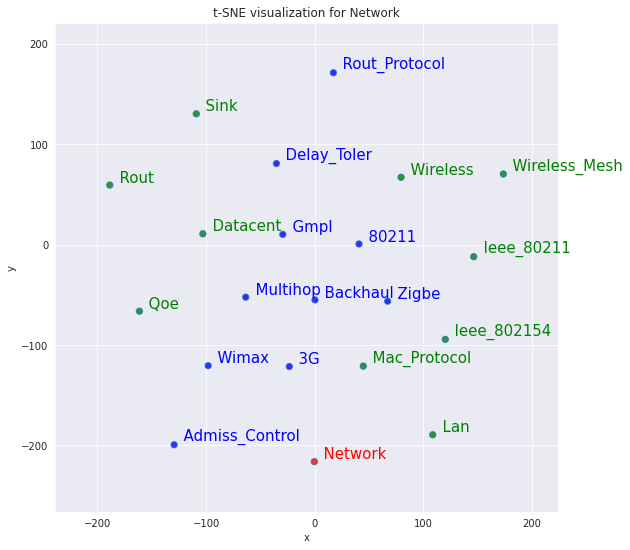

In [10]:
#10 Most similar words vs. 11th to 20th Most similar words:
tsnescatterplot(model, "network", [t[0] for t in model.wv.most_similar(positive=["network"], topn=20)][10:])

In [11]:
path = '{}/models/'.format(DATA_PATH)
Path(path).mkdir(exist_ok=True)

model_file = '{}/word2vec.model'.format(path)
model.wv.save_word2vec_format(model_file, binary=True)

INFO - 11:25:25: storing 5384x300 projection weights into ./data/models//word2vec.model
